In [936]:
library(RBGL)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
#library(tibble)
library("rjson")

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

In [937]:
config <- fromJSON(file = "config.json")

In [938]:
directory <- config$output_dir
dims <- config$graphs$sampled$algorithms$generateDAGMaxParents$dims[[1]]
sample_sizes <- config$data$sample_sizes[[1]]
replicates <- config$data$replicates$start:config$data$replicates$end
dag_avparents <-config$graphs$sampled$algorithms$generateDAGMaxParents$av_parents[[1]]

In [939]:
sample_sizes
dims
replicates
dag_avparents

[1] 100

[1] 5

[1] 1 2

[1] 2

In [940]:
rjson::fromJSON('[[[1,0], [0,1]]]', simplify = TRUE)


[[1]]
[[1]][[1]]
[1] 1 0

[[1]][[2]]
[1] 0 1

In [941]:
config

$output_dir
[1] "simresults"

$data
$data$replicates
$data$replicates$start
[1] 1

$data$replicates$end
[1] 2


$data$sample_sizes
[1] 100


$graphs
$graphs$sampled
$graphs$sampled$algorithms
$graphs$sampled$algorithms$generateDAGMaxParents
$graphs$sampled$algorithms$generateDAGMaxParents$av_parents
[1] 2

$graphs$sampled$algorithms$generateDAGMaxParents$dims
[1] 5




$graphs$fixed
list()


$evaluation
$evaluation$score
$evaluation$score$bdecatpar
$evaluation$score$bdecatpar$chi
[1] 1

$evaluation$score$bdecatpar$edgepf
[1] 1




$algorithms
$algorithms$blip
$algorithms$blip$plot_legend
[1] "blip"

$algorithms$blip$scorer.method
[1] "is"

$algorithms$blip$solver.method
[1] "winasobs"

$algorithms$blip$indeg
[1] 80

$algorithms$blip$time
[1] 10

$algorithms$blip$allocated
[1] 80

$algorithms$blip$scorefunction
[1] "bdeu"

$algorithms$blip$alpha
[1] 1

$algorithms$blip$cores
[1] 1

$algorithms$blip$verbose
[1] 0


$algorithms$gobnilp
$algorithms$gobnilp$plot_legend
[1] "gobnilp"

$algorithms$gobnilp$plot
[1] FALSE

$algorithms$gobnilp$palim
[1] 2


$algorithms$fges
$algorithms$fges$plot_legend
[1] "fges"

$algorithms$fges$faithfulnessAssumed
[1] 1


$algorithms$pcalg
$algorithms$pcalg$plot_legend
[1] "pcalg"

$algorithms$pcalg$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45


$algorithms$mmhc
$algorithms$mmhc$plot_legend
[1] "mmhc"

$algorithms$mmhc$restrict.args
$algorithms$mmhc$restrict.args$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45



$algorithms$itsearch_map
$algorithms$itsearch_map$plot_legend
[1] "itmap"

$algorithms$itsearch_map$optional
$algorithms$itsearch_map$optional$MAP
[1] 1

$algorithms$itsearch_map$optional$plus1it
NULL

$algorithms$itsearch_map$optional$posterior
NULL


$algorithms$itsearch_map$score_params
$algorithms$itsearch_map$score_params$bdecatpar
$algorithms$itsearch_map$score_params$bdecatpar$chi
[1] 1

$algorithms$itsearch_map$score_params$bdecatpar$edgepf
[1] 1




$algorithms$itsearch_sample
$algorithms$itsearch_sample$plot_legend
[1] "itsample"

$algorithms$itsearch_sample$optional
$algorithms$itsearch_sample$optional$MAP
[1] 0

$algorithms$itsearch_sample$optional$plus1it
[1] 6

$algorithms$itsearch_sample$optional$posterior
[1] 0.5


$algorithms$itsearch_sample$score_params
$algorithms$itsearch_sample$score_params$bdecatpar
$algorithms$itsearch_sample$score_params$bdecatpar$chi
[1] 1

$algorithms$itsearch_sample$score_params$bdecatpar$edgepf
[1] 1




$algorithms$ordermcmc_map
$algorithms$ordermcmc_map$plot_legend
[1] "omcmc_itmap"

$algorithms$ordermcmc_map$startspace
[1] "itsearch_map"

$algorithms$ordermcmc_map$optional
$algorithms$ordermcmc_map$optional$plus1
[1] TRUE


$algorithms$ordermcmc_map$score_params
$algorithms$ordermcmc_map$score_params$bdepar
$algorithms$ordermcmc_map$score_params$bdepar$chi
[1] 1

$algorithms$ordermcmc_map$score_params$bdepar$edgepf
[1] 1



$algorithms$ordermcmc_map$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20


$algorithms$ordermcmc_sample
$algorithms$ordermcmc_sample$plot_legend
[1] "omcmc_itsample"

$algorithms$ordermcmc_sample$startspace
[1] "itsearch_sample"

$algorithms$ordermcmc_sample$optional
$algorithms$ordermcmc_sample$optional$plus1
[1] TRUE


$algorithms$ordermcmc_sample$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20

$algorithms$ordermcmc_sample$score_params
$algorithms$ordermcmc_sample$score_params$bdepar
$algorithms$ordermcmc_sample$score_params$bdepar$chi
[1] 1

$algorithms$ordermcmc_sample$score_params$bdepar$edgepf
[1] 1

### Order MCMC

In [942]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/orderMCMC"), recursive=TRUE)
ROCdf_order_mcmc_itsearch_map <- data.frame()
ROCdf_order_mcmc_itsearch_sample <- data.frame()
ROCdf_order_mcmc <- data.frame()

tmpdf <- NULL
for (filename in filenames) {
    tmpdf <- read.csv(file.path(directory, "res/orderMCMC", filename))
    ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [943]:
ROCdf_order_mcmc

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,map,⋯,gamma,hardlimit,chainout,scoreout,verbose,threshold,startspace_method,startspace_params,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<lgl>,⋯,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<chr>
1.0,0.2,-151.7566,1,2,1,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1/plus1it_None/posterior_None,3.26,omcmc_itmap
1.0,0.0,-180.8388,3,2,2,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1/plus1it_None/posterior_None,3.05,omcmc_itmap
1.0,0.2,-151.7566,1,2,1,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0/plus1it_6/posterior_0.5,3.47,omcmc_itsample
1.0,0.0,-180.8388,3,2,2,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0/plus1it_6/posterior_0.5,3.04,omcmc_itsample
1.0,0.0,-163.8295,0,2,1,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1/plus1it_None/posterior_None,3.26,omcmc_itmap
1.0,0.0,-180.8388,3,2,2,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1/plus1it_None/posterior_None,3.05,omcmc_itmap
1.0,0.0,-167.8168,0,2,1,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0/plus1it_6/posterior_0.5,3.47,omcmc_itsample
1.0,0.0,-180.8388,3,2,2,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0/plus1it_6/posterior_0.5,3.04,omcmc_itsample
1.0,0.0,-170.1508,0,2,1,orderMCMC,5,100,NA,⋯,1,15,True,False,False,0.4,itsearch,map_1/plus1it_None/posterior_None,3.26,omcmc_itmap


In [944]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>%
                    filter(replicate %in% replicates) %>%
                    # filter(is.na(itsearch_plus1it) | (itsearch_plus1it %in% config$itsearch_sample$optional$plus1it)) %>%
                    group_by(legend, threshold, sample_size, dim, avparents) %>% 
                    summarise(SHD_mean = mean(SHD),
                              TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time_mean = mean(time),
                              logscore_mean = mean(logscore),
                              N = n()) #%>%
                    #filter(N %in% length(replicates))

In [945]:
labels <- apply(sumROC_order_mcmc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sumROC_order_mcmc["labels"] <- labels

In [946]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,5,2,2.0,1.0,1.0,0.1,1.00,1.00,3.155,-166.2977,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.30,100,5,2,1.5,1.0,1.0,0.0,1.00,1.00,3.155,-172.3342,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.40,100,5,2,1.5,0.9,0.9,0.0,0.81,0.99,3.155,-186.4683,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.50,100,5,2,2.5,0.9,0.9,0.0,0.81,0.99,3.155,-220.9970,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.60,100,5,2,4.0,0.4,0.4,0.0,0.40,0.40,3.155,-257.5729,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.70,100,5,2,4.5,0.2,0.2,0.0,0.20,0.20,3.155,-282.5835,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.80,100,5,2,5.0,0.1,0.1,0.0,0.01,0.19,3.155,-295.0812,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.90,100,5,2,5.0,0.0,0.0,0.0,0.00,0.00,3.155,-308.7759,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.95,100,5,2,5.0,0.0,0.0,0.0,0.00,0.00,3.155,-308.7759,2,"p=5, n=100, avparents=2, N=2"


### Iterative MCMC

In [947]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/itsearch"), recursive = TRUE)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory,"res/itsearch", filename))
  # Convert "None" string to NA
    tmpdf["plus1it"] <- na_if(tmpdf["plus1it"], "None")
   tmpdf["posterior"] <- na_if(tmpdf["posterior"], "None")
    ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
  
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [948]:
ROCdf_itsearch

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,plus1it,⋯,mergetype,addspace,scoretable,startorder,accum,score_type,bdecatpar_chi,bdecatpar_edgepf,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<lgl>,<lgl>,<lgl>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>
1.0000000,0.0000000,-174.8460,4,2,1,itsearch,5,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,11.52,itsample
1.0000000,0.0000000,-195.2717,0,2,2,itsearch,5,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,12.18,itsample
1.0000000,0.0000000,-151.1296,0,2,1,itsearch,5,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,8.44,itmap
1.0000000,0.0000000,-162.2757,3,2,2,itsearch,5,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,8.09,itmap
0.6250000,0.2250000,-3891.9464,78,2,1,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,75.39,itsample
0.6455696,0.1898734,-4078.7376,70,2,10,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,84.04,itsample
0.6750000,0.1750000,-3579.8347,59,2,11,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,70.73,itsample
0.5443038,0.2658228,-3914.1802,79,2,12,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,83.34,itsample
0.6835443,0.2278481,-3974.9593,76,2,13,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,87.20,itsample


In [949]:
#ROCdf_itsearch$algorithm <- apply(ROCdf_itsearch["MAP"], 1, 
# function(a){
#    if(a==TRUE){ 
#        return("itsearch_map")
#     }else {
#        return("itsearch_sample")
#      }
#  })                                          

In [950]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%
                filter(is.na(plus1it) | (plus1it %in% config$itsearch_sample$optional$plus1it)) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                           time_mean = mean(time),
                         #  it_mean = mean(it),
                          N = n()) #%>%
                    #filter(N %in% length(replicates))0

labels <- apply(sum_roc_itsearch, 1, function(row) {
    paste("p=",row["dim"],", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_itsearch["labels"] <- labels 

In [951]:
labels

[1] "p=5, n=100, avparents=2, N=2"

In [952]:
sum_roc_itsearch

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,time_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
itmap,100,5,2,1.5,1,1,0,1,1,-156.7027,8.265,2,"p=5, n=100, avparents=2, N=2"


### PC algorithm

In [953]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/pcalg"), recursive = TRUE)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/pcalg", filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [954]:
roc_pcalg

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,alpha,dim,sample_size,⋯,fixedEdges,NAdelete,m.max,conservative,maj.rule,solve.confl,numCores,verbose,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<dbl>,<int>,<int>,⋯,<lgl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>
0.2000000,0.00000000,-236.3767,4,2,1,pcalg,0.01,5,100,⋯,NA,True,Inf,False,False,False,1,False,3.04,pcalg
0.8000000,0.00000000,-214.9495,5,2,2,pcalg,0.01,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.68,pcalg
0.6000000,0.00000000,-160.4199,2,2,1,pcalg,0.05,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.79,pcalg
0.8000000,0.00000000,-214.9495,5,2,2,pcalg,0.05,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.65,pcalg
0.8000000,0.00000000,-153.2172,1,2,1,pcalg,0.10,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.90,pcalg
1.0000000,0.00000000,-191.8639,5,2,2,pcalg,0.10,5,100,⋯,NA,True,Inf,False,False,False,1,False,3.19,pcalg
0.6000000,0.00000000,-157.8851,2,2,1,pcalg,0.20,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.83,pcalg
1.0000000,0.00000000,-195.2717,0,2,2,pcalg,0.20,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.17,pcalg
1.0000000,0.00000000,-174.8460,4,2,1,pcalg,0.35,5,100,⋯,NA,True,Inf,False,False,False,1,False,2.81,pcalg


In [955]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                 filter(sample_size %in% sample_sizes) %>%         
                 filter(avparents %in% dag_avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise(
                          SHD_mean = mean(SHD),
                          TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          time_mean = mean(time),
                          N = n())# %>% ungroup() %>%
#                 filter(N %in% replicates)
labels <- apply(sum_roc_pcalg, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_pcalg["labels"] <- labels 

In [956]:
sum_roc_pcalg

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
pcalg,0.01,100,5,2,4.5,0.5,0.5,0,0.23,0.77,2.860,2,"p=5, n=100, avparents=2, N=2"
pcalg,0.05,100,5,2,3.5,0.7,0.7,0,0.61,0.79,2.720,2,"p=5, n=100, avparents=2, N=2"
pcalg,0.10,100,5,2,3.0,0.9,0.9,0,0.81,0.99,3.045,2,"p=5, n=100, avparents=2, N=2"
pcalg,0.20,100,5,2,1.0,0.8,0.8,0,0.62,0.98,2.500,2,"p=5, n=100, avparents=2, N=2"
pcalg,0.35,100,5,2,2.0,1.0,1.0,0,1.00,1.00,3.055,2,"p=5, n=100, avparents=2, N=2"
pcalg,0.45,100,5,2,2.0,1.0,1.0,0,1.00,1.00,2.925,2,"p=5, n=100, avparents=2, N=2"


### Max-Min hill climbing

In [957]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/mmhc"), recursive = TRUE)

roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/mmhc", filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [958]:
roc_mmhc

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,bdecatpar_chi,bdecatpar_edgepf,alpha,whitelist,debug,maximize.args,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<lgl>,<fct>,<lgl>,<dbl>,<fct>
0.4000000,0.00000000,-231.8679,3,2,1,mmhc,5,100,bde,1,1,0.01,NA,False,NA,2.60,mmhc
0.8000000,0.00000000,-229.0859,3,2,2,mmhc,5,100,bde,1,1,0.01,NA,False,NA,2.16,mmhc
0.6000000,0.00000000,-205.6324,2,2,1,mmhc,5,100,bde,1,1,0.05,NA,False,NA,3.38,mmhc
0.8000000,0.00000000,-229.0859,3,2,2,mmhc,5,100,bde,1,1,0.05,NA,False,NA,3.30,mmhc
0.6000000,0.00000000,-203.9791,2,2,1,mmhc,5,100,bde,1,1,0.10,NA,False,NA,3.10,mmhc
1.0000000,0.00000000,-228.2769,0,2,2,mmhc,5,100,bde,1,1,0.10,NA,False,NA,3.17,mmhc
0.6000000,0.00000000,-203.9791,2,2,1,mmhc,5,100,bde,1,1,0.20,NA,False,NA,2.69,mmhc
1.0000000,0.00000000,-228.2769,0,2,2,mmhc,5,100,bde,1,1,0.20,NA,False,NA,3.02,mmhc
0.8000000,0.00000000,-201.9890,1,2,1,mmhc,5,100,bde,1,1,0.35,NA,False,NA,2.80,mmhc


In [959]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_mmhc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_mmhc["labels"] <- labels 

In [960]:
sum_roc_mmhc

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
mmhc,0.01,100,5,2,3.0,0.6,0.6,0,0.42,0.78,2.380,2,"p=5, n=100, avparents=2, N=2"
mmhc,0.05,100,5,2,2.5,0.7,0.7,0,0.61,0.79,3.340,2,"p=5, n=100, avparents=2, N=2"
mmhc,0.10,100,5,2,1.0,0.8,0.8,0,0.62,0.98,3.135,2,"p=5, n=100, avparents=2, N=2"
mmhc,0.20,100,5,2,1.0,0.8,0.8,0,0.62,0.98,2.855,2,"p=5, n=100, avparents=2, N=2"
mmhc,0.35,100,5,2,0.5,0.9,0.9,0,0.81,0.99,2.905,2,"p=5, n=100, avparents=2, N=2"
mmhc,0.45,100,5,2,0.5,0.9,0.9,0,0.81,0.99,2.650,2,"p=5, n=100, avparents=2, N=2"


## FGES

In [961]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/fges"), recursive = TRUE)

roc_fges <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/fges", filename))
  roc_fges <- dplyr::bind_rows(roc_fges, tmpdf)
}

In [962]:
roc_fges

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,faithfulnessAssumed,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<dbl>,<fct>
1.0000000,0.00000000,-151.1296,0,2,1,fges,5,100,bde,1,2.39,fges
0.8000000,0.00000000,-161.1689,3,2,2,fges,5,100,bde,1,2.03,fges
0.6375000,0.03750000,-3591.7183,50,2,1,fges,80,100,bde,1,3.51,fges
0.6202532,0.03797468,-3832.0047,56,2,10,fges,80,100,bde,1,4.10,fges
0.6250000,0.03750000,-3415.7592,52,2,11,fges,80,100,bde,1,3.32,fges
0.5316456,0.01265823,-3683.6787,62,2,12,fges,80,100,bde,1,3.85,fges
0.5949367,0.03797468,-3853.5369,56,2,13,fges,80,100,bde,1,3.86,fges
0.4814815,0.03703704,-3865.0204,59,2,14,fges,80,100,bde,1,3.60,fges
0.7000000,0.00000000,-3606.3131,48,2,15,fges,80,100,bde,1,3.96,fges


In [963]:
sum_roc_fges <- roc_fges %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_fges, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_fges["labels"] <- labels 

In [964]:
sum_roc_fges

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
fges,100,5,2,1.5,0.9,0.9,0,0.81,0.99,2.21,2,"p=5, n=100, avparents=2, N=2"


### Blip

In [975]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/blip"), recursive = TRUE)

ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/blip", filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [982]:
ROCdf_blip

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,⋯,scorer.method,solver.method,indeg,cores,allocated,scorefunction,alpha,verbose,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<fct>
1.0000000,0.000000,-199.6550,0,2,1,blip,5,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,5.11,blip
1.0000000,0.000000,-228.2769,0,2,2,blip,5,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,5.12,blip
0.8500000,1.512500,-3796.4196,170,2,1,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.41,blip
0.8101266,1.303797,-3989.4726,153,2,10,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.62,blip
0.8000000,1.887500,-3485.3440,205,2,11,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.29,blip
0.7215190,1.544304,-3819.8503,167,2,12,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,14.08,blip
0.8481013,1.227848,-3938.1336,148,2,13,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.72,blip
0.7654321,1.246914,-4053.5575,152,2,14,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.72,blip
0.8625000,1.237500,-3798.6152,136,2,15,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.88,blip


# Fix so that scores are calculated on the same data set

In [983]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore", "max_time")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates)
rename(blip_scores, logscore_blip=logscore)

legend,replicate,avparents,sample_size,dim,logscore_blip,max_time
<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>
blip,1,2,100,5,-199.6550,10
blip,2,2,100,5,-228.2769,10


In [968]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore", "max_time")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
blip_scores <- rename(blip_scores, logscore_blip=logscore)
blip_scores <- rename(blip_scores, legend_blip=legend)


itsearch_scores <- ROCdf_itsearch %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
itsearch_scores <- rename(itsearch_scores, logscore_itsearch=logscore)
itsearch_scores <- rename(itsearch_scores, legend_itsearch=legend)

order_mcmc_scores <- ROCdf_order_mcmc %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
order_mcmc_scores <- rename(order_mcmc_scores, logscore_order_mcmc=logscore)
order_mcmc_scores <- rename(order_mcmc_scores, legend_order_mcmc=legend)

#blip_scores
#itsearch_scores
#order_mcmc_scores

cols <- c("replicate", "avparents", "sample_size", "dim")

scores <- left_join(blip_scores, itsearch_scores, by=cols)
scores$blip_minus_itsearch <- scores$logscore_blip - scores$logscore_itsearch
difflogscore_itsearch <- scores

#print(difflogscore_itsearch)
#scores <- blip_scores %>% left_join(itsearch_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch")) %>%
#        left_join(order_mcmc_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch"), name="test")
difflogscore_itsearch <- difflogscore_itsearch %>% 
                         group_by(legend_itsearch, sample_size, dim, avparents) %>% 
                         summarise(logscore_mean=mean(blip_minus_itsearch),        
                        N=n())

labels <- apply(difflogscore_itsearch, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})


# TODO: Compare to one of the blip max_times
difflogscore_itsearch["labels"] <- labels 

difflogscore_itsearch

legend_itsearch,sample_size,dim,avparents,logscore_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<int>,<chr>
itmap,100,5,2,-57.26329,2,"p=5, n=100, avparents=2, N=2"
itsample,100,5,2,-28.90715,2,"p=5, n=100, avparents=2, N=2"


In [969]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


In [986]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%      
                filter(replicate %in% replicates) %>%
                filter(indeg %in% config$algorithms$blip$indeg) %>%
                 group_by(legend, sample_size, dim,max_time, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR),
                          time_mean=mean(time),
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           logscore_mean = mean(logscore),
                          N = n())#%>%
                    #filter(N %in% replicates)
labels <- apply(sum_roc_blip, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_blip["labels"] <- labels 

In [987]:
sum_roc_blip

legend,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
blip,100,5,10,2,0,1,5.115,1,0,1,1,-213.966,2,"p=5, n=100, avparents=2, N=2"


### GoBNiLP

In [988]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/gobnilp"), recursive = TRUE)

ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/gobnilp", filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [989]:
ROCdf_gobnilp

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,bdecatpar_chi,bdecatpar_edgepf,palim,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
1.0000000,0.0000000,-222.6897,0,2,1,gobnilp,5,100,bde,1,1,2,0.059684,gobnilp
1.0000000,0.0000000,-254.9438,0,2,2,gobnilp,5,100,bde,1,1,2,0.124581,gobnilp
0.7750000,0.9625000,-4262.3110,136,2,1,gobnilp,80,100,bde,1,1,2,1.251101,gobnilp
0.8354430,0.8481013,-4459.0551,116,2,10,gobnilp,80,100,bde,1,1,2,0.727223,gobnilp
0.7875000,1.0125000,-3955.4800,131,2,11,gobnilp,80,100,bde,1,1,2,6.364006,gobnilp
0.7721519,1.0000000,-4271.1203,118,2,12,gobnilp,80,100,bde,1,1,2,8.944864,gobnilp
0.8481013,0.8734177,-4394.4448,121,2,13,gobnilp,80,100,bde,1,1,2,9.044705,gobnilp
0.7160494,0.9876543,-4492.5709,134,2,14,gobnilp,80,100,bde,1,1,2,6.850025,gobnilp
0.8375000,0.9500000,-4260.6239,116,2,15,gobnilp,80,100,bde,1,1,2,9.536967,gobnilp


In [990]:
sum_roc_gobnilp <- ROCdf_gobnilp %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>%          
                filter(replicate %in% replicates) %>%
                   group_by(legend, sample_size, dim, avparents, palim) %>% 
                 summarise( SHD_mean = mean(SHD),
                     TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n())#%>%
                    #filter(N %in% length(replicates))
labels <- apply(sum_roc_gobnilp, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_gobnilp["labels"] <- labels 

In [991]:
sum_roc_gobnilp

legend,sample_size,dim,avparents,palim,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
gobnilp,100,5,2,2,0,1,1,0,1,1,0.0921325,2,"p=5, n=100, avparents=2, N=2"


In [992]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,5,2,2.0,1.0,1.0,0.1,1.00,1.00,3.155,-166.2977,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.30,100,5,2,1.5,1.0,1.0,0.0,1.00,1.00,3.155,-172.3342,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.40,100,5,2,1.5,0.9,0.9,0.0,0.81,0.99,3.155,-186.4683,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.50,100,5,2,2.5,0.9,0.9,0.0,0.81,0.99,3.155,-220.9970,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.60,100,5,2,4.0,0.4,0.4,0.0,0.40,0.40,3.155,-257.5729,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.70,100,5,2,4.5,0.2,0.2,0.0,0.20,0.20,3.155,-282.5835,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.80,100,5,2,5.0,0.1,0.1,0.0,0.01,0.19,3.155,-295.0812,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.90,100,5,2,5.0,0.0,0.0,0.0,0.00,0.00,3.155,-308.7759,2,"p=5, n=100, avparents=2, N=2"
omcmc_itmap,0.95,100,5,2,5.0,0.0,0.0,0.0,0.00,0.00,3.155,-308.7759,2,"p=5, n=100, avparents=2, N=2"


## Plot ROC curves

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Saving 6.67 x 6.67 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warnin

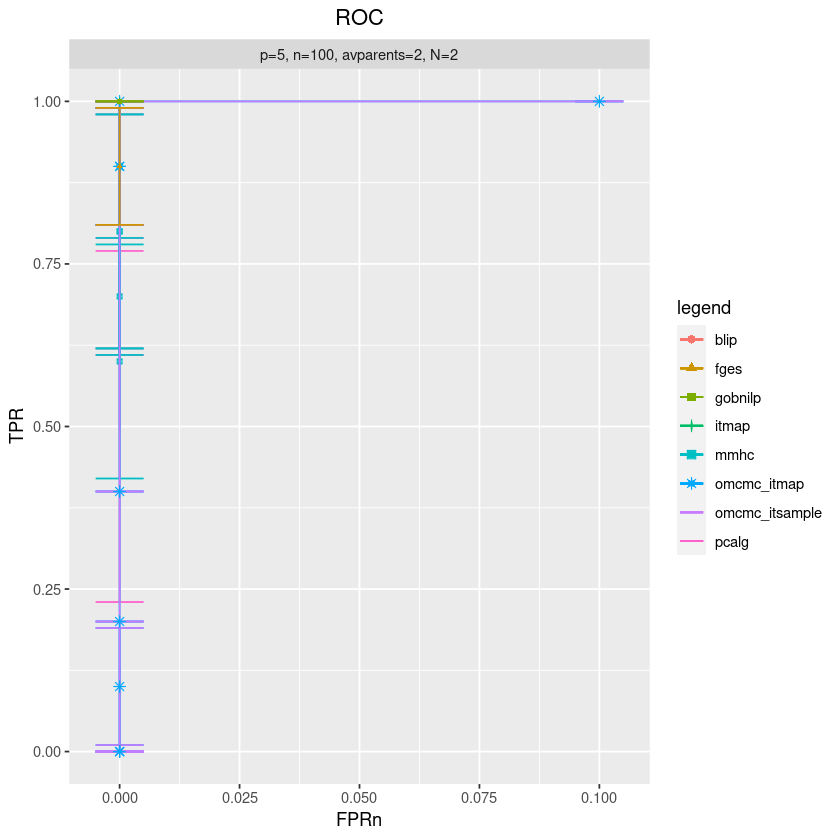

In [993]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
 #geom_text(data = sum_roc_pcalg,
 #           aes(x = FPRn_median, 
 #               y = TPR_q3,               
 #               label=alpha, col=legend),
 #         check_overlap = TRUE,
 #          nudge_x=-0.02,
 #         nudge_y=0.02
 #         ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=legend),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = legend, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Gobnilp
 geom_errorbar(data = sum_roc_gobnilp,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_gobnilp,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# FGES
 geom_errorbar(data = sum_roc_fges,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_fges,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_fges,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# Subplot
# 

# put full label in the dataframe and save it as label.
# then write  facet_wrap(. ~ label)

#facet_wrap(. ~ dim + avparents + sample_size + N, scales="free_x", nrow = 2) +
facet_wrap(. ~ labels, scales="free_x", nrow = 2) +

# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

In [933]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_mmhc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 15), legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_x") +
#ylab("Mean SHD") +
#xlab("Algorithm") 
#ggsave(file=file.path("SHD.eps"))

## Logscores

In [934]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


## Times

In [935]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = time_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = time_mean,
#             col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
#facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
#ylab("Mean run time (s)") +
#xlab("Algorithm") 
#ggsave(file=file.path("runtimes.eps"))